**Disclaimer**: I use a word "we" when describing something I've done, but this is an individual work.

In [238]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
from helpers import plot_categories, print_number_of_nans, print_number_of_distinct_values, build_graph, train_and_save_model, get_nn_embeddings, get_graph_embeddings
import itertools
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import compute_class_weight
import json
from gensim.models import Word2Vec
import lightgbm 
import tqdm

In [239]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
data_dir = 'data'
graph_embedding_file_model = 'node2vec_model'
nn_embedding_file_model = 'neural_network.h5'

In [241]:
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))

### EDA

unitDisplayType
brandName
bundleId
appVersion
correctModelName
countryCode
osAndVersion
connectionType
c1
c3
mediationProviderVersion


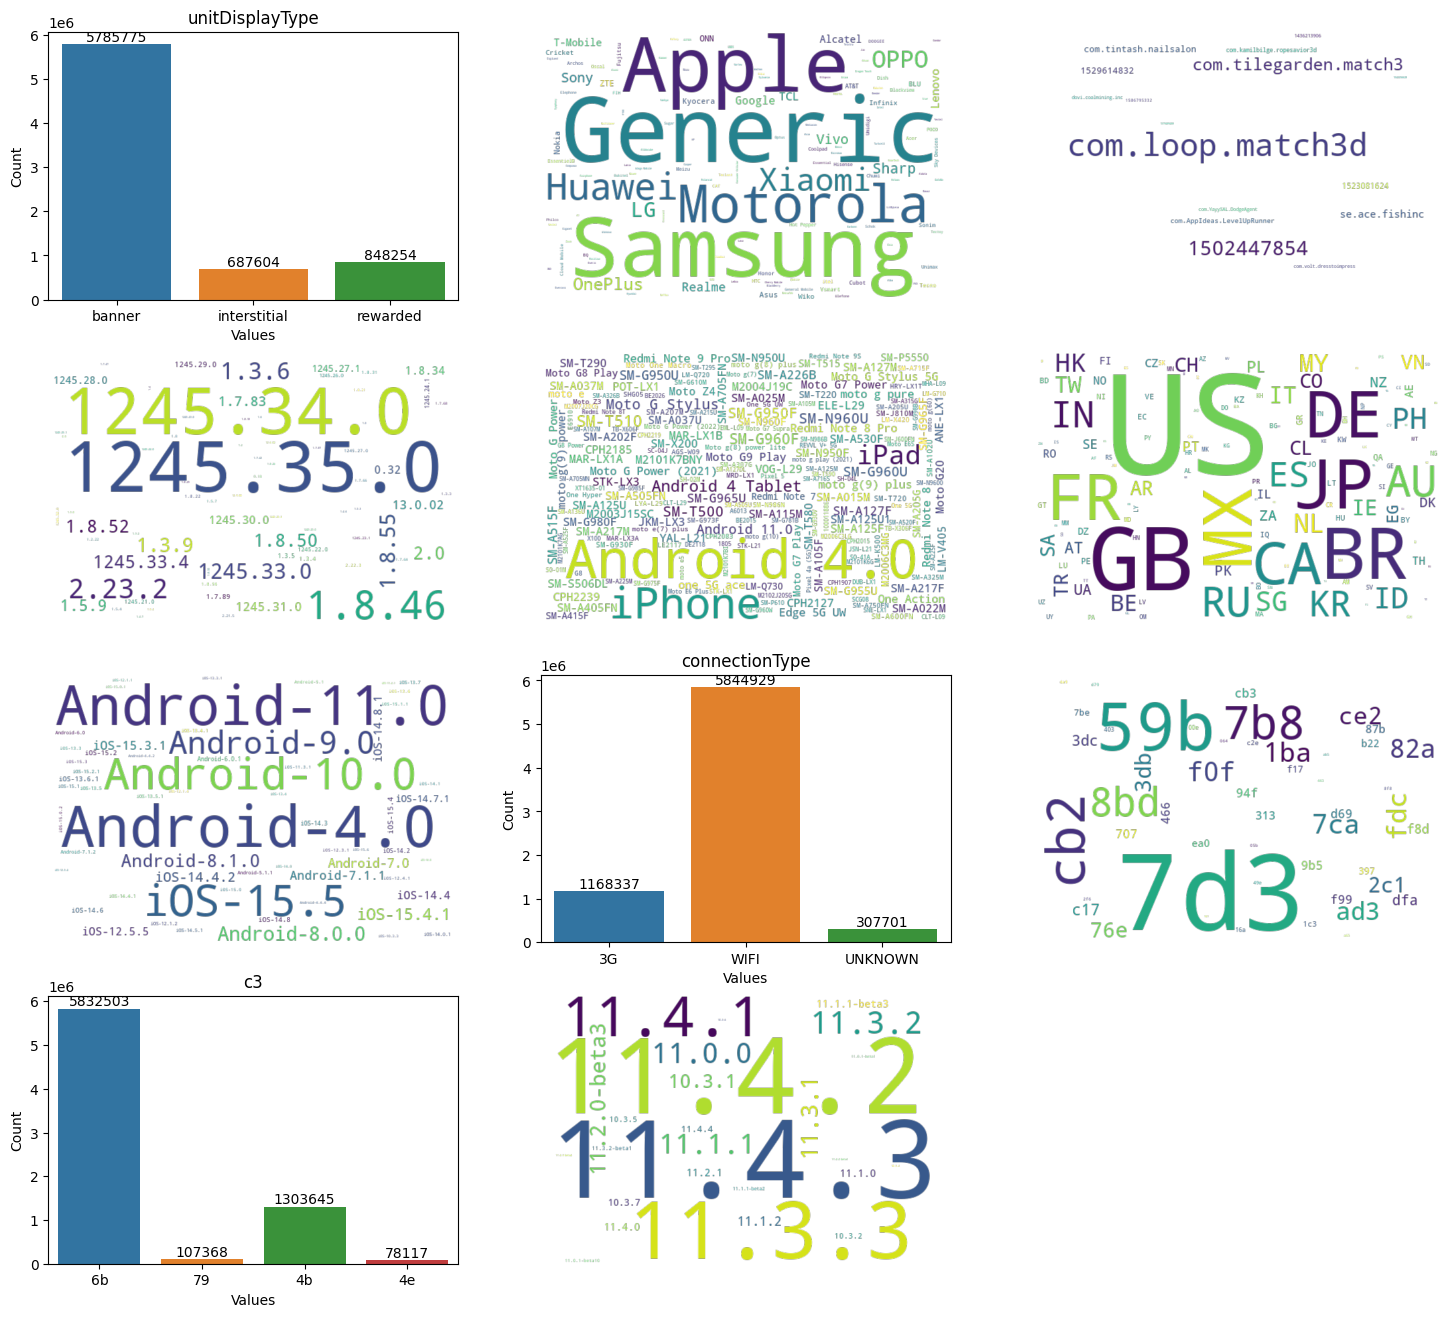

In [242]:
categorical_columns = ['unitDisplayType', 'brandName', 'bundleId', 'appVersion', 'correctModelName', 'countryCode',
'osAndVersion', 'connectionType','c1','c3', 'mediationProviderVersion']
categorical_columns_len = len(categorical_columns)
ncols = 3
nrows = len(categorical_columns) // ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,4*nrows))
axs = axs.flatten()
for ax_idx, (col, ax) in enumerate(zip(categorical_columns, axs)): 
    print(col)
    plot_categories(train_df[col], ax=ax)
for i in range(ax_idx+1, ncols*nrows): 
    axs[i].axis('off')

In [243]:
print_number_of_distinct_values(train_df)

Number of distinct values in columns: 
eventTimestamp 7302171
unitDisplayType 3
brandName 144
bundleId 18
appVersion 101
correctModelName 2568
countryCode 169
deviceId 40176
osAndVersion 96
connectionType 4
c1 50
c2 9
c3 4
c4 9
size 6
mediationProviderVersion 35
bidFloorPrice 4
sentPrice 7521
winBid 23008
has_won 2


#### NaNs

In [244]:
print_number_of_nans(train_df)

Rows with nans in columns: 
countryCode 27
connectionType 666


In [245]:
print_number_of_nans(test_df)

Rows with nans in columns: 
countryCode 6
connectionType 17


We could get rid of 27 samples of empty `countryCode` but NaNs are also present in test set. So we change NaNs to "UNKNOWN". We do it also in `connectionType` where "UNKNOWN" is already present in the data.

In [246]:
test_df = test_df.fillna("UNKNOWN")
train_df = train_df.fillna("UNKNOWN")

The distribution is skewed to the right, so we will try to predict logarithm of a target as well. 

<AxesSubplot:>

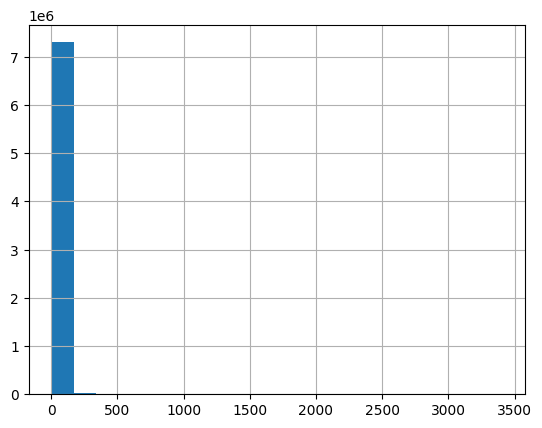

In [247]:
train_df['winBid'].hist(bins=20)

In [248]:
train_df['winBid_log'] = train_df['winBid'].apply(np.log)

<AxesSubplot:>

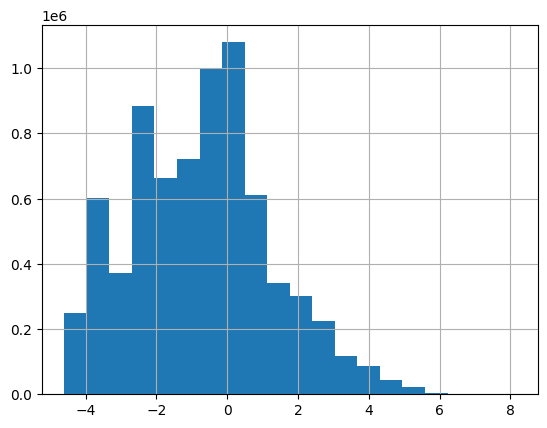

In [249]:
train_df['winBid_log'].hist(bins=20)

### Feature crafting

- columns_to_one_hot will just be one-hot encoded
- columns_to_cut_one_hot will be cut to values before first dot (so for example 1.3.6 will be just 1) and then one-hot encoded
- high_cardinality_columns will be encoded using three special method described below 

In [250]:
columns_to_one_hot = ['unitDisplayType', 'connectionType', 'bundleId']
columns_to_cut_one_hot = ['mediationProviderVersion', 'osAndVersion', 'appVersion']
high_cardinality_columns = ['correctModelName', 'countryCode', 'brandName', 'c1','c3']

One approach is to create a graph with nodes representing unique values from the five columns defined above. The edge weights in this graph will be based on how frequently two corresponding values appear together in rows. For instance, if Xiaomi is frequently used in Poland (PL), the edge between the nodes representing Xiaomi and PL will have a high weight. Once the graph is constructed, we can calculate the embeddings of the nodes using the Node2Vec algorithm (available at https://github.com/aditya-grover/node2vec).

In [ ]:
graph, mapping = build_graph(train_df[high_cardinality_columns])
with open('mapping.json', 'w') as file: 
    json.dump(mapping, file)
node2vec = Node2Vec(graph, dimensions=3, walk_length=30, num_walks=100, workers=1)
model = node2vec.fit(window=5, min_count=1, batch_words=4) 
model.save(graph_embedding_file_model)

In [251]:
graph_model = Word2Vec.load(graph_embedding_file_model)
with open('mapping.json', 'r') as file: 
    mapping = json.load(file)

To utilize the has_won attribute, we will construct a simple neural network with fully connected layers to predict whether a bid has been won or not. As input, we will utilize a one-hot encoded version of the high-cardinality columns. Once the network is trained, we will extract the output from the penultimate layer to encode the information from those five columns. This approach may seem counter-intuitive, as those columns might not inherently contain the necessary information for predicting bid outcomes. However, the purpose of using the neural network is to reduce dimensionality and utilize the encoded representation in the next steps.

In [ ]:
train_and_save_model(train_df[high_cardinality_columns], train_df['has_won'], nn_embedding_file_model)

In [ ]:
nn_model = tf.keras.models.load_model(nn_embedding_file_model)

The last method involves calculating the means of the target variables (both transformed and non-transformed) for each unique value in the five columns. Additionally, we perform the same calculation for the deviceId column.

All of these methods have a common flaw - they are computed using the entire training set. This can potentially lead to data leakage, where information from the validation set is incorporated into the model. Given more time, this issue should be  addressed.

In [135]:
means_maps = {}
fill_map = {}
log_means_maps = {}
log_fill_map = {}
for col in ['correctModelName', 'countryCode', 'brandName', 'c1', 'c3', 'deviceId']:
    means_maps[col] = train_df.groupby(col)['winBid'].mean()
    fill_map[col] = means_maps[col].mean()
    log_means_maps[col] = train_df.groupby(col)['winBid_log'].mean()
    log_fill_map[col] = log_means_maps[col].mean()

In [192]:
def add_features(df, categories=None, fillna_graph_methods=[0,0,0]):
    df = df.copy()
    df['event_datetime'] = pd.to_datetime(df['eventTimestamp'], unit='ms')
    df['hour'] = df['event_datetime'].dt.hour
    df['day_of_week'] = df['event_datetime'].dt.dayofweek
    df['week_of_year'] = df['event_datetime'].dt.isocalendar().week
    for col in columns_to_cut_one_hot: 
        df[col] = df[col].apply(lambda x: x.split('.')[0])
    df = pd.get_dummies(df, columns=columns_to_cut_one_hot+columns_to_one_hot)
    

        
    graph_embeddings = get_graph_embeddings(df[high_cardinality_columns], graph_model, mapping, fillna_graph_methods)
    for i in range(graph_embeddings.shape[1]):
        df[f'graph_features_{i}'] = graph_embeddings[:, i]
    
    nn_embeddings = get_nn_embeddings(df[high_cardinality_columns], nn_model, categories=categories)
    for i in range(nn_embeddings.shape[1]):
        df[f'nn_features_{i}'] = nn_embeddings[:, i]
    
    df[['size_dim1', 'size_dim2']] = df[['size']].apply(lambda size: [int(dim) for dim in size.values[0].split('x')], axis=1, result_type='expand')
    df['area'] = df['size_dim1']*df['size_dim2']
    
    for col, series_map in means_maps.items():
        df[f'{col}_target_mean'] = df[col].map(series_map).fillna(fill_map[col])

    for col, series_map in log_means_maps.items():
        df[f'{col}_log_target_mean'] = df[col].map(series_map).fillna(log_fill_map[col])
    
    df['week_of_year'] = df['week_of_year'].apply(int)
    return df


In [137]:
train_df_with_features_path = 'train_df_with_features.feather'
if os.path.exists(train_df_with_features_path): 
    train_df_with_features = pd.read_feather(train_df_with_features_path)
else: 
    train_df_with_features = add_features(train_df)
    train_df_with_features.to_feather(train_df_with_features_path)

In [140]:
base_columns = ['c2', 'c4', 'bidFloorPrice', 'sentPrice', 'size_dim1', 'size_dim2', 'hour', 'day_of_week', 'week_of_year', 'mediationProviderVersion_10', 'mediationProviderVersion_11', 'osAndVersion_Android-10', 'osAndVersion_Android-11', 'osAndVersion_Android-4', 'osAndVersion_Android-5', 'osAndVersion_Android-6', 'osAndVersion_Android-7', 'osAndVersion_Android-8', 'osAndVersion_Android-9', 'osAndVersion_iOS-10', 'osAndVersion_iOS-11', 'osAndVersion_iOS-12', 'osAndVersion_iOS-13', 'osAndVersion_iOS-14', 'osAndVersion_iOS-15', 'osAndVersion_iOS-16', 'appVersion_0', 'appVersion_1', 'appVersion_12', 'appVersion_1245', 'appVersion_13', 'appVersion_2', 'unitDisplayType_banner', 'unitDisplayType_interstitial', 'unitDisplayType_rewarded', 'connectionType_3G', 'connectionType_UNKNOWN', 'connectionType_WIFI', 'bundleId_1436213906', 'bundleId_1502447854', 'bundleId_1523081624', 'bundleId_1529614832', 'bundleId_1542256628', 'bundleId_1569586264', 'bundleId_1579489488', 'bundleId_1582745578', 'bundleId_1586795332', 'bundleId_com.AppIdeas.LevelUpRunner', 'bundleId_com.YayySAL.DodgeAgent', 'bundleId_com.kamilbilge.ropesavior3d', 'bundleId_com.loop.match3d', 'bundleId_com.tilegarden.match3', 'bundleId_com.tintash.nailsalon', 'bundleId_com.volt.dresstoimpress', 'bundleId_dovi.coalmining.inc', 'bundleId_se.ace.fishinc', 'area', 'deviceId_target_mean']
graph_feature_cols = [col for col in train_df_with_features.columns if 'graph_' in col]
nn_feature_cols = [col for col in train_df_with_features.columns if 'nn_' in col]
mean_feature_cols = [col for col in train_df_with_features.columns if '_mean' in col and 'device' not in col]
log_mean_feature_cols = [col for col in train_df_with_features.columns if '_mean' in col and 'device' not in col and 'log' in col]

In [143]:
train_X_y, val_X_y = train_test_split(train_df_with_features, test_size=0.2)

In [147]:
params = {'metric': 'rmse',
    'bagging_fraction': 0.75,
    'max_depth': 15,
    'n_estimators': 5000}

experiments = [{'x_cols': base_columns + graph_feature_cols,
    'y_col': 'winBid'},
    {'x_cols': base_columns + nn_feature_cols,
    'y_col': 'winBid'},
    {'x_cols': base_columns + mean_feature_cols,
    'y_col': 'winBid'},
    {'x_cols': base_columns + graph_feature_cols+nn_feature_cols+mean_feature_cols,
    'y_col': 'winBid'},
    {'x_cols': base_columns + graph_feature_cols,
    'y_col': 'winBid_log'},
    {'x_cols': base_columns + nn_feature_cols,
    'y_col': 'winBid_log'},
    {'x_cols': base_columns + log_mean_feature_cols,
    'y_col': 'winBid_log'},
    {'x_cols': base_columns + graph_feature_cols+nn_feature_cols+log_mean_feature_cols,
    'y_col': 'winBid_log'}]

In [149]:
best_model = None
best_rmse = 99999
for experiment in tqdm.tqdm(experiments): 
    model = lightgbm.LGBMRegressor(**params)
    model.fit(train_X_y[experiment['x_cols']], 
              train_X_y[experiment['y_col']], 
              eval_set=(val_X_y[experiment['x_cols']], val_X_y[experiment['y_col']]),
              callbacks=[lightgbm.early_stopping(100)])
    y_pred_val = model.predict(val_X_y[experiment['x_cols']], num_iteration=model.best_iteration_)
    if 'log' in experiment['y_col']: 
        y_pred_val = np.exp(y_pred_val)
    
    experiment['val_rmse'] = ((y_pred_val - val_X_y['winBid'])**2).mean()**0.5
    if experiment['val_rmse'] < best_rmse: 
        best_rmse = experiment['val_rmse']
        best_model = model

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4999]	valid_0's rmse: 9.34587


 12%|██████████▍                                                                        | 1/8 [05:10<36:11, 310.23s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4954]	valid_0's rmse: 9.29835


 25%|████████████████████▊                                                              | 2/8 [10:27<31:24, 314.12s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4990]	valid_0's rmse: 9.36989


 38%|███████████████████████████████▏                                                   | 3/8 [15:10<25:01, 300.21s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4982]	valid_0's rmse: 9.25416


 50%|█████████████████████████████████████████▌                                         | 4/8 [21:36<22:15, 333.89s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 0.680573


 62%|███████████████████████████████████████████████████▉                               | 5/8 [27:24<16:57, 339.17s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 0.681434


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [33:12<11:24, 342.21s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 0.683883


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [38:29<05:33, 333.94s/it]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 0.675243


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [46:29<00:00, 348.73s/it]



Things that we would fix when given more time: 
- Add cross validiation to better evaluate the model.
- Prevent data leakage.
- Perform a grid search to optimize LGBMRegressor parameters.
- Use more estimators (early stopping conditions weren't often met).

Text(0, 0.5, 'Features')

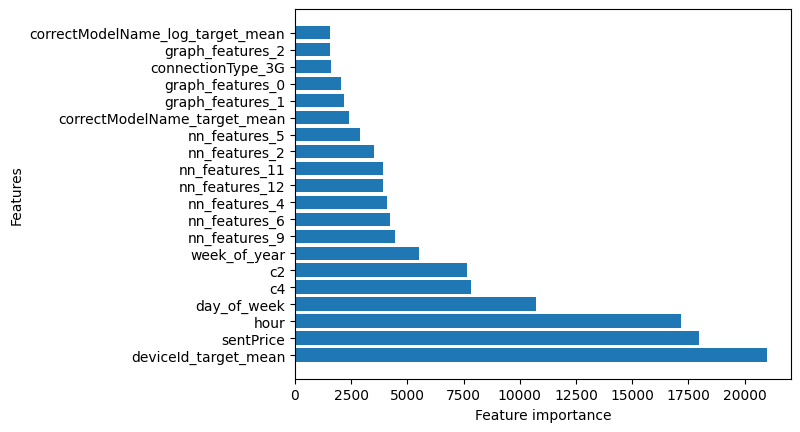

In [180]:
imp_argsort = np.argsort(best_model.feature_importances_)[::-1][:20]
imp_sorted = best_model.feature_importances_[imp_argsort]
sorted_names = np.array(best_model.feature_name_)[imp_argsort]

plt.barh(sorted_names, imp_sorted)
plt.xlabel('Feature importance')
plt.ylabel('Features')

Based on this plot, it is clear that the features generated from the neural network are not among the top seven most effective features. However, they still provide value to the model. On the other hand, the graph features demonstrate a decent level of performance. Surprisingly, the simpler features outperform both the neural network and graph features, indicating their superiority in terms of predictive power. Best feature is mean target value for single deviceId which can suggest problem with data leakage. 

In [194]:
max_value = max(mapping.values())
fillna_graph_methods = np.array([list(graph_model.wv[(node_id,)].flatten()) for node_id in range(max_value + 1)]).mean(axis=0)
fillna_graph_methods = list(fillna_graph_methods)

In [213]:
categories = {col: train_df[col].drop_duplicates().tolist() for col in high_cardinality_columns}
test_df_with_features = add_features(test_df, categories, fillna_graph_methods=fillna_graph_methods)

C:\Users\kszku\Desktop\MINI\sem4\digital_turbine\helpers.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(mapping).map(node_id_to_node_emb)
C:\Users\kszku\Desktop\MINI\sem4\digital_turbine\helpers.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: fillna_graph_methods if isinstance(x, float) else x)  # can't fillna with lists :(
100%|███████████████████████████████████████████████████████████████████████████████| 650/650 [00:02<00:00, 232.31it/

In [223]:
best_experiment = min(experiments, key=lambda x: x['val_rmse'])
best_experiment['y_col'], best_experiment['val_rmse']

('winBid', 9.254162486114865)

In [230]:
y_pred = best_model.predict(test_df_with_features[best_model.feature_name_], num_iteration=best_model.best_iteration_)

In [235]:
submission = test_df_with_features[['deviceId']]
submission['winBid'] = np.clip(y_pred, test_df_with_features['bidFloorPrice'], max(y_pred))
submission.head()

C:\Users\kszku\miniconda3\envs\mgr_vqe\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,deviceId,winBid
0,6a0a94554cf,17.737443
1,6a0b0e59f45,3.453165
2,6a0fa820c46,3.067203
3,6a142bdbea2,0.391360
4,6a16943a771,1.126183


In [236]:
submission.to_csv('sub.csv', index=False)